In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

**Description:-** 

1. **TensorFlow** is an open-source library developed by Google primarily for deep learning applications. It also supports traditional machine learning. TensorFlow was originally developed for large numerical computations without keeping deep learning in mind.

2. The **ImageDataGenerator** class in Keras is used for implementing image augmentation. The major advantage of the Keras ImageDataGenerator class is its ability to produce real-time image augmentation. This simply means it can generate augmented images dynamically during the training of the model making the overall mode more robust and accurate.

3. **Tqdm** is a Python library used to display smart progress bars that show the progress of your Python code execution. This library can also be used to see the progress of a machine learning model while training the model on a very large data set. Sometimes it takes a lot of time while training a machine learning model on a very huge dataset.

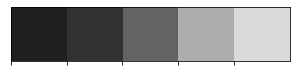

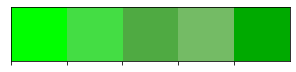

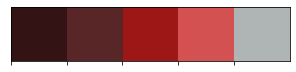

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#AFB4B4']
colors_green = ['#00ff00','#44DD44','#4FAA42','#74BB65','#00AA00']
sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

## Data **Preperation**

In [ ]:
labels = ['glioma','notumor','meningioma','pituitary']

In [ ]:
X_train = []
y_train = []
image_size = 150

In [ ]:
for i in labels:
    folderPath = os.path.join('gdrive/MyDrive/Brain_Tumor_prediction/Training',i)
    for j in tqdm(os.listdir(folderPath), ncols = 120, desc = 'Training: '+str(i)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

Training: pituitary: 100%|██████████████████████████████████████████████████████████| 1457/1457 [00:25<00:00, 57.74it/s]


In [ ]:
for i in labels:
    folderPath = os.path.join('gdrive/MyDrive/Brain_Tumor_prediction/Testing',i)
    for j in tqdm(os.listdir(folderPath), ncols = 120, desc = 'Testing: '+str(i)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

Testing: pituitary: 100%|█████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 66.73it/s]


findfont: Font family ['comic-sans'] not found. Falling back to DejaVu Sans.


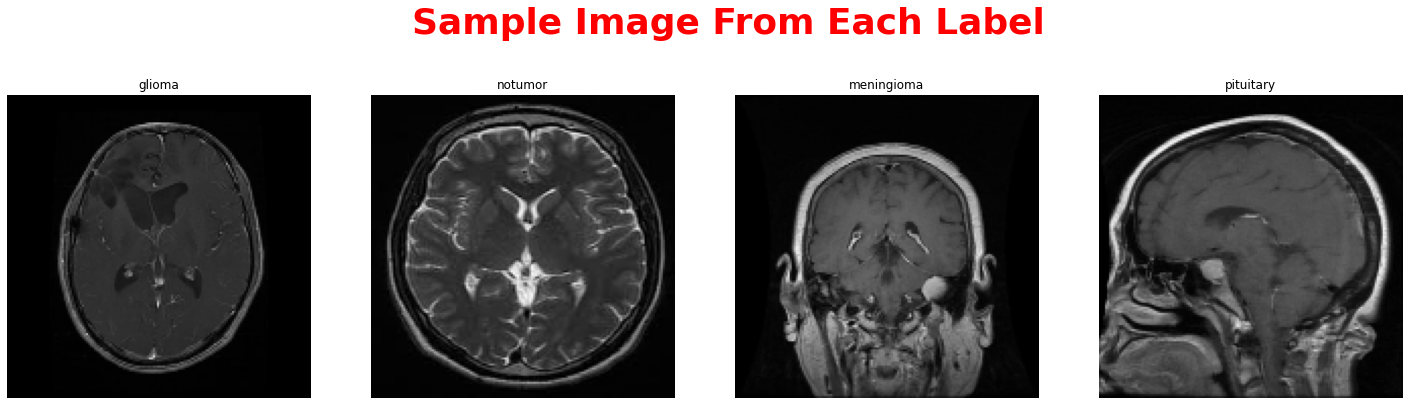

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(25,20))
fig.text(s='Sample Image From Each Label',size=36,fontweight='bold',
             fontname='comic-sans',color='#ff0000',y=0.65,x=0.35,alpha=1)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=44)

In [ ]:
print("X_train: ", X_train.shape,'\n',"y_train: ", y_train.shape)

X_train:  (7025, 150, 150, 3) 
 y_train:  (7025,)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
print('X_train-shape:', X_train.shape,'\ny_train-shape: ', y_train.shape, '\nX_tset-shape: ', X_test.shape, '\ny_test-shape: ', y_test.shape)

X_train-shape: (6322, 150, 150, 3) 
y_train-shape:  (6322,) 
X_tset-shape:  (703, 150, 150, 3) 
y_test-shape:  (703,)


In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [ ]:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# ***`implementing EfficeentNetB0...`***

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16719872/16705208 [==============================] - 0s 0us/step


#Transfer learning

In [ ]:
effnet_model = effnet.output
effnet_model = tf.keras.layers.GlobalAveragePooling2D()(effnet_model)
effnet_model = tf.keras.layers.Dropout(rate=0.5)(effnet_model)
effnet_model = tf.keras.layers.Dense(4,activation='softmax')(effnet_model)
effnet_model = tf.keras.models.Model(inputs=effnet.input, outputs = effnet_model)

In [ ]:
effnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

In [ ]:
effnet_model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

In [ ]:
effnet_history = effnet_model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32, callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
  7/178 [>.............................] - ETA: 10:15 - loss: 0.9548 - accuracy: 0.6205

KeyboardInterrupt: ignored

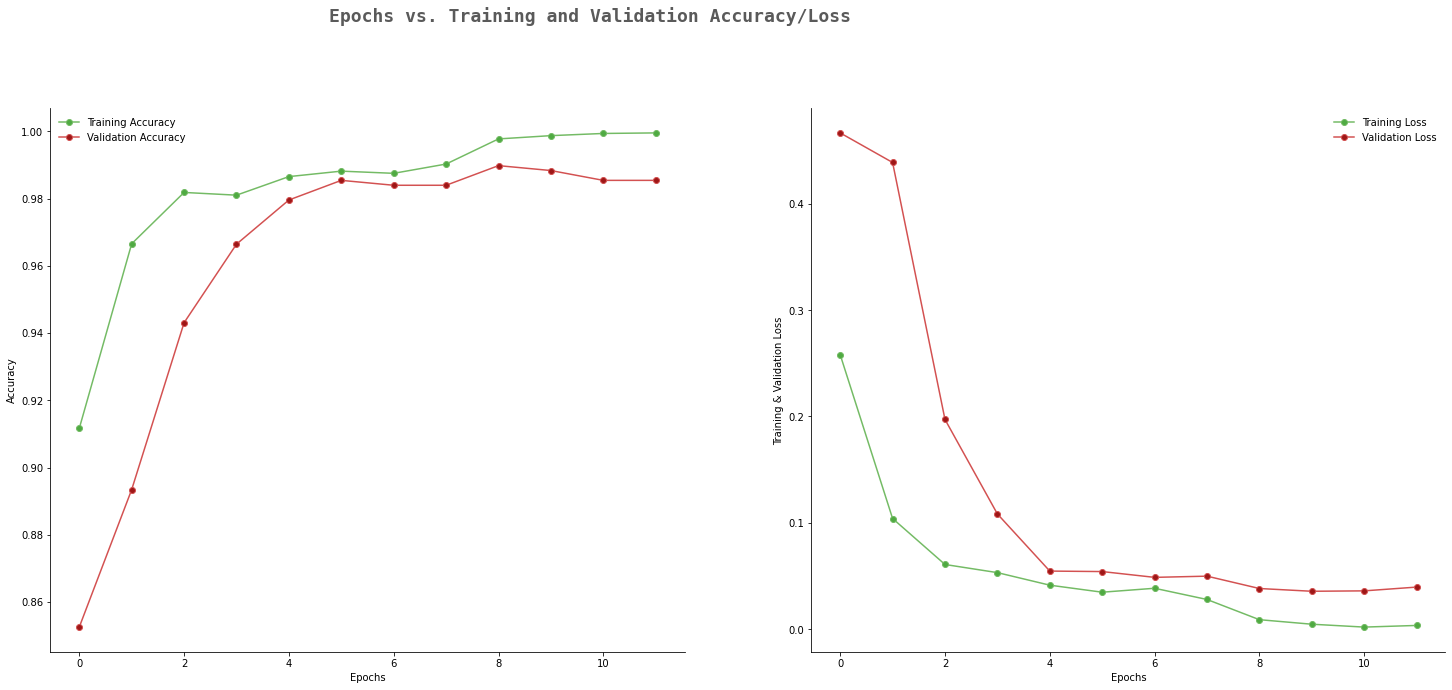

In [ ]:
filterwarnings('ignore')
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(25,10))
train_acc = effnet_history.history['accuracy']
train_loss = effnet_history.history['loss']
val_acc = effnet_history.history['val_accuracy']
val_loss = effnet_history.history['val_loss']
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)
sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3], label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3], label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3], label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3], label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
fig.show()

In [ ]:
pred = effnet_model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       176
           1       1.00      0.99      1.00       240
           2       0.99      0.99      0.99       169
           3       0.99      1.00      1.00       176

    accuracy                           0.99       761
   macro avg       0.99      1.00      0.99       761
weighted avg       0.99      0.99      0.99       761



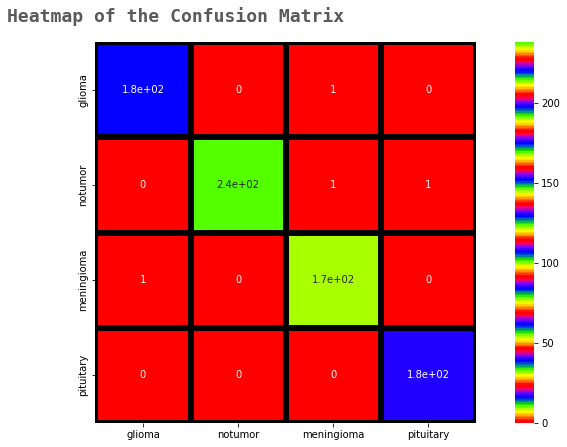

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True, cmap='prism',alpha=1,linewidths=5,linecolor='black', square=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold', fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
print("Model accuracy is: ",np.round(accuracy_score(y_test_new, pred),2)*100,'%.')

Model accuracy is:  99.0 %.
